In [ ]:
!pip install datasets transformers sentence-transformers pinecone-client pinecone-text langchain openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.6/31

In [ ]:
import os
# 1f. Import Google Colab library to access key
from google.colab import userdata
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = userdata.get('PINECONE_API_KEY')

# configure client
pc = Pinecone(api_key=api_key)

In [ ]:
from pinecone import ServerlessSpec
import time

cloud = 'aws'
region ='us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

# choose a name for your index
index_name = "search-hybrid"

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=512,
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [ ]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [ ]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

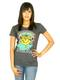

In [ ]:
# display a product image
images[200]

In [ ]:
# convert metadata into a pandas dataframe
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
#
doc_model_id = "naver/efficient-splade-VI-BT-large-doc"
doc_tokenizer = AutoTokenizer.from_pretrained(doc_model_id)
doc_model = AutoModelForMaskedLM.from_pretrained(doc_model_id)
#
query_model_id = "naver/efficient-splade-VI-BT-large-query"
query_tokenizer = AutoTokenizer.from_pretrained(query_model_id)
query_model = AutoModelForMaskedLM.from_pretrained(query_model_id)

tokenizer_config.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/417 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device : {device}")
# load a CLIP model from huggingface
dense_model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
print(dense_model)

device : cuda


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

SentenceTransformer(
  (0): CLIPModel()
)


In [ ]:
import torch

def compute_vector(text, tokenizer, sparse_model):
    """
    Computes a vector from logits and attention mask using ReLU, log, and max operations.
    """
    tokens = tokenizer(text,return_tensors="pt",padding=True)
    output = sparse_model(**tokens)
    logits, attention_mask = output.logits, tokens.attention_mask
    relu_log = torch.log(1 + torch.relu(logits))
    weighted_log = relu_log * attention_mask.unsqueeze(-1)
    max_val, _ = torch.max(weighted_log, dim=1)
    vec = max_val.squeeze()

    return vec, tokens

In [ ]:
from tqdm.auto import tqdm

batch_size = 1
indices  = []
values = []
final_embeddings = []
meta_dict_list=[]
ids_list=[]
upserts = []
for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="index")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds,sparsetokens = compute_vector([text for text in meta_batch],doc_tokenizer,doc_model)
    query_indices = sparse_embeds.nonzero().numpy().flatten()
    query_values = sparse_embeds.detach().numpy()[query_indices]
    #print(query_indices)
    #print(query_values)
    query_values_of_floats = [float(x) for x in query_values]
    indices.append(query_indices)
    values.append(query_values_of_floats)
    # create dense vectors
    dense_embeds = dense_model.encode(img_batch).tolist()
    #print(dense_embeds)
    #dense_embeds_of_floats = [float(x) for x in dense_embeds]
    final_embeddings.append(dense_embeds[0])
    meta_dict_list.append(meta_dict)
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]
    ids_list.append(str(i))

    # loop through the data and create dictionaries for uploading documents to pinecone index
    #for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        # build sparse values dictionary
    #    sparse_values = {
    #        "indices": indices,
    #        "values": values
     #   }
      #  upserts.append({
       #     'id': _id,
        #    'sparse_values': sparse,
         #   'values': dense,
          #  'metadata': meta
        #})
    # upload the documents to the new hybrid index



  0%|          | 0/44072 [00:00<?, ?it/s]

In [ ]:
from tqdm import tqdm

batch_size = 200
upserts = []

for i in tqdm(range(0, len(fashion), batch_size)):
    print(f"i : {i}")
    end = i + batch_size
    batch_indices = indices[i:end]
    batch_values = values[i:end]
    batch_embeddings = final_embeddings[i:end]
    batch_ids = ids_list[i:end]
    batch_meta_dict = meta_dict_list[i:end]
    #print(batch_meta_dict)
    for j in range(len(batch_indices)):
        print(f"j : {j}")
        sparse_values = {
            "indices": batch_indices[j],
            "values": batch_values[j]
        }
        batch_meta_dict_new = batch_meta_dict[j].get(i+j)
        upserts.append({
            'id': batch_ids[j],
            'sparse_values': sparse_values,
            'values': batch_embeddings[j],
            'metadata': batch_meta_dict_new
        })

    # Upsert the current batch
    index.upsert(upserts)
    # Clear the upserts list for the next batch
    upserts.clear()

# Show index description after uploading the documents
index.describe_index_stats()

In [ ]:
query = "dark blue french connection jeans for men"

# create sparse and dense vectors
#sparse = bm25.encode_queries(query)
#dense = model.encode(query).tolist()

dense_vec = dense_model.encode("Men Navy Blue Track pant")
dense_vec.shape
query_text = "Men Navy Blue Track pant"
query_vec, query_tokens = compute_vector(query_text,query_tokenizer,query_model)
query_vec.shape

query_indices = query_vec.nonzero().numpy().flatten()
query_values = query_vec.detach().numpy()[query_indices]
# Searching for similar documents
sparse_values = {
      "indices": query_indices.tolist(),
      "values": query_values.tolist()
  }
# search
result = index.query(
    top_k=14,
    vector=dense_vec.tolist(),
    sparse_vector=sparse_values,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>]

In [ ]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


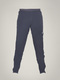
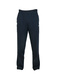
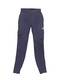
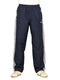
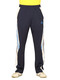
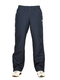
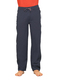
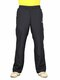
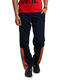
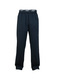
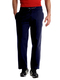
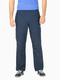
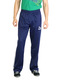
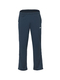

In [ ]:
display_result(imgs)

In [ ]:
def hybrid_scale(dense, query_indices,query_values, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': query_indices,
        'values':  [v * (1 - alpha) for v in query_values]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse


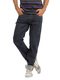
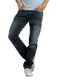
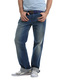
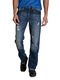
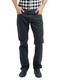
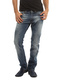
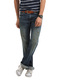
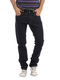
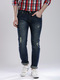
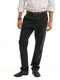
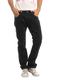
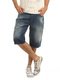
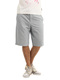
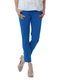

In [ ]:
question = "dark blue french connection jeans for men"

dense_vec = dense_model.encode(question)
dense_vec.shape
query_text = question
query_vec, query_tokens = compute_vector(query_text,query_tokenizer,query_model)
query_vec.shape

query_indices = query_vec.nonzero().numpy().flatten()
query_values = query_vec.detach().numpy()[query_indices]

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense_vec.tolist(), query_indices.tolist(),query_values.tolist(), alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
French Connection Men Navy Blue Jeans
French Connection Navy Washed Skinny Stretchable Jeans
French Connection Men Bluish Grey Trousers
French Connection Men Navy Blue Trousers
French Connection Men Blue Denim Shorts
French Connection Men Blue Striped Shorts
French Connection Women Blue Jeans



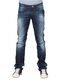
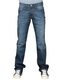
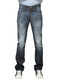
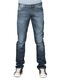
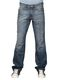
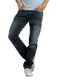
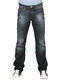
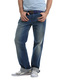
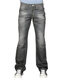
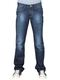
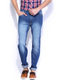
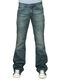
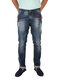
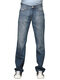

In [ ]:
# scale sparse and dense vectors
#hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
hdense, hsparse = hybrid_scale(dense_vec.tolist(), query_indices.tolist(),query_values.tolist(), alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Locomotive Men Radley Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Cam Blue Jeans
Locomotive Men Ian Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Cael Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Barney Grey Jeans
Locomotive Men Lio Blue Jeans
John Players Men Blue Jeans
Locomotive Men Rafe Blue Jeans
Spykar Men Actif Fit Low Waist Blue Jeans
Locomotive Men Lain Blue Jeans



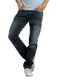
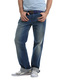
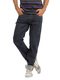
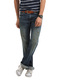
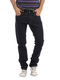
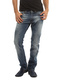
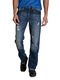
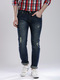
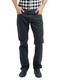
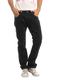
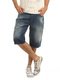
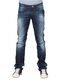
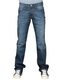
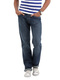

In [ ]:
# scale sparse and dense vectors
#hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
hdense, hsparse = hybrid_scale(dense_vec.tolist(), query_indices.tolist(),query_values.tolist(), alpha=0.5)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [ ]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
French Connection Men Navy Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Navy Washed Skinny Stretchable Jeans
French Connection Men Blue Jeans
French Connection Men Navy Blue Trousers
French Connection Men Blue Denim Shorts
Locomotive Men Radley Blue Jeans
Locomotive Men Eero Blue Jeans
Pepe Jeans Men Dark Blue Jeans
